In [11]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import networkx as nx


Defining some graph

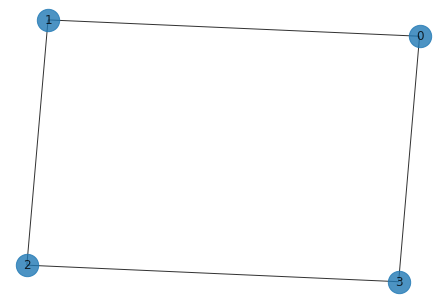

In [12]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

# Mixing unitary
Defining quantum circuit with 4 qbits and adding: $$R_x(2\beta)=e^{-i\beta\hat{\sigma}_x}=\begin{pmatrix}cos(\beta)  -sin(\beta) \\ -isin(\beta)cos(\beta)\end{pmatrix},\quad\quad \hat{\sigma}_x=\begin{pmatrix}0\,1\\1\,0\end{pmatrix}$$ to each

In [13]:
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
#adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter(r'\beta')
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw()

┌─────────────┐
q_0: ┤ Rx(2*\beta) ├
     ├─────────────┤
q_1: ┤ Rx(2*\beta) ├
     ├─────────────┤
q_2: ┤ Rx(2*\beta) ├
     ├─────────────┤
q_3: ┤ Rx(2*\beta) ├
     └─────────────┘

# Problem unitary
Defining another quantum circuit, adding 4 qbits and adding $$e^{-i\gamma\hat{\sigma}_{z,i}\hat{\sigma}_{z,j}},\quad\quad\hat{\sigma}_z=\begin{pmatrix}1\,0\\0\,-1\end{pmatrix}$$

In [14]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw()

░                              ░      »
q_0: ──■──────────────────────■───░───■──────────────────────■───░──────»
     ┌─┴─┐┌────────────────┐┌─┴─┐ ░   │                      │   ░      »
q_1: ┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──────────────────────┼───░───■──»
     └───┘└────────────────┘└───┘ ░   │                      │   ░ ┌─┴─┐»
q_2: ─────────────────────────────░───┼──────────────────────┼───░─┤ X ├»
                                  ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ └───┘»
q_3: ─────────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░──────»
                                  ░ └───┘└────────────────┘└───┘ ░      »
«                             ░                              ░ 
«q_0: ────────────────────────░──────────────────────────────░─
«                             ░                              ░ 
«q_1: ────────────────────■───░──────────────────────────────░─
«     ┌────────────────┐┌─┴─┐ ░                              ░ 
«q_2: ┤ Rz(2*$\gamma$) ├┤ X ├─░───■──────────────────────■───░─
«     └────────────────┘└───┘ ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░ 
«q_3: ────────────────────────░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░─
«                             ░ └───┘└────────────────┘└───┘ ░

# Initial state
Preparing inital state in equal superposition 

In [15]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

# Assembling entire QAOA


In [16]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

┌─────────┐┌──────────────┐                             ░      »
q_0: ┤ U2(0,π) ├┤ R(2*\beta,0) ├──■──────────────────────■───░───■──»
     ├─────────┤├──────────────┤┌─┴─┐┌────────────────┐┌─┴─┐ ░   │  »
q_1: ┤ U2(0,π) ├┤ R(2*\beta,0) ├┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───┼──»
     ├─────────┤├──────────────┤└───┘└────────────────┘└───┘ ░   │  »
q_2: ┤ U2(0,π) ├┤ R(2*\beta,0) ├─────────────────────────────░───┼──»
     ├─────────┤├──────────────┤                             ░ ┌─┴─┐»
q_3: ┤ U2(0,π) ├┤ R(2*\beta,0) ├─────────────────────────────░─┤ X ├»
     └─────────┘└──────────────┘                             ░ └───┘»
«                             ░                              ░      »
«q_0: ────────────────────■───░──────────────────────────────░──────»
«                         │   ░                              ░      »
«q_1: ────────────────────┼───░───■──────────────────────■───░──────»
«                         │   ░ ┌─┴─┐┌────────────────┐┌─┴─┐ ░      »
«q_2: ────────────────────┼───░─┤ X ├┤ Rz(2*$\gamma$) ├┤ X ├─░───■──»
«     ┌────────────────┐┌─┴─┐ ░ └───┘└────────────────┘└───┘ ░ ┌─┴─┐»
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░──────────────────────────────░─┤ X ├»
«     └────────────────┘└───┘ ░                              ░ └───┘»
«                             ░ 
«q_0: ────────────────────────░─
«                             ░ 
«q_1: ────────────────────────░─
«                             ░ 
«q_2: ────────────────────■───░─
«     ┌────────────────┐┌─┴─┐ ░ 
«q_3: ┤ Rz(2*$\gamma$) ├┤ X ├─░─
«     └────────────────┘└───┘ ░

In [17]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())        # Number of qubits = number of nodes in graph 
    p = len(theta)//2               # Number of alternating unitaries
    qc = QuantumCircuit(nqubits)    # Initializing Q circuit w. nqubits nr. of qbits
    
    beta = theta[:p]                # Beta opt param for mixing unitaries as first p vals.
    gamma = theta[p:]               # Gama opt param for cost unitaries as last p vals.
    
    # Initial_state: Hadamark gate on each qbit
    for i in range(0, nqubits):
        qc.h(i)
    
    # Cost unitary: Z_i*Z_j on pair[0], pair[1] qbits
    for irep in range(0, p):        
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

    # mixer unitary: X rotation on each qbit      
    for irep in range(0, p): 
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        return compute_expectation(counts, G) ## Returns the expectation of graph, given counts
    
    return execute_circ



In [18]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=2)

res = minimize(fun = expectation, x0 = [1.0,1.0], method='COBYLA')
res

{'1110': 27, '1011': 27, '1000': 31, '1001': 69, '0101': 44, '1010': 65, '0011': 81, '0001': 34, '0110': 66, '0010': 26, '0000': 182, '0111': 35, '1101': 28, '1111': 205, '0100': 26, '1100': 78}
{'1110': 3, '1011': 2, '0010': 1, '1001': 109, '0000': 44, '0011': 96, '0001': 8, '0110': 108, '0101': 231, '0111': 4, '1101': 2, '1111': 48, '1000': 2, '0100': 2, '1100': 115, '1010': 249}
{'1000': 15, '0101': 20, '1110': 18, '1011': 15, '1001': 81, '1010': 23, '0100': 8, '1100': 89, '0111': 17, '0001': 18, '0011': 73, '1101': 14, '1111': 275, '0110': 82, '0010': 15, '0000': 261}
{'1000': 60, '1011': 48, '1001': 42, '0010': 55, '0000': 25, '0101': 178, '0110': 53, '0111': 52, '0001': 46, '0011': 41, '1101': 60, '1111': 20, '0100': 44, '1100': 45, '1110': 59, '1010': 196}
{'1000': 68, '0110': 42, '1100': 34, '0100': 70, '1001': 34, '0101': 59, '1110': 55, '0011': 42, '0001': 52, '1010': 81, '0000': 109, '0010': 58, '1101': 58, '1111': 126, '0111': 62, '1011': 74}
{'1011': 29, '1000': 41, '1001'

     fun: -2.994140625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.97958006, 1.16618482])

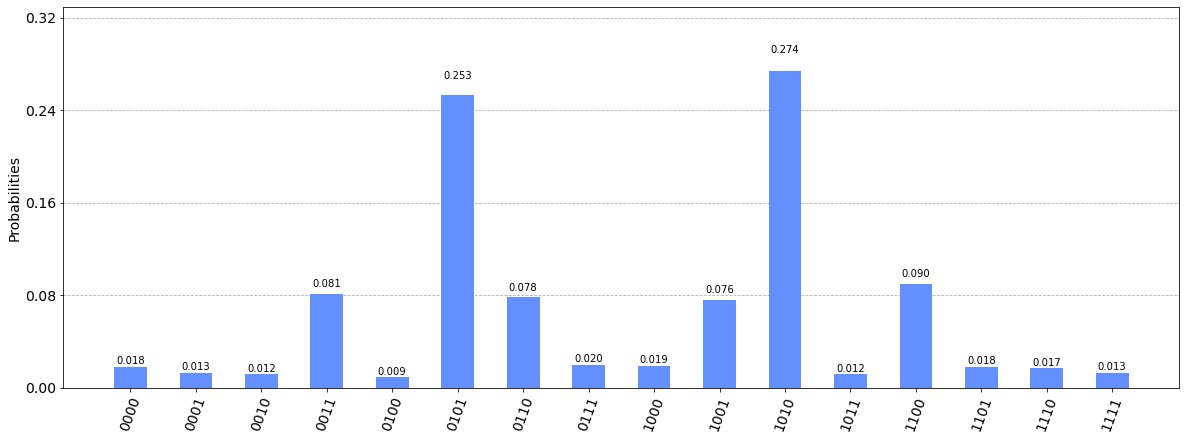

In [19]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts,figsize=(20,7))